# Data Preparation Tutorial

The purpose of this tutorial is to provide a guide about how to prepare data from combinatorial phenotypic screening reuslts into a format parsable by NAIAD.

NAIAD expects the data as a CSV with the following columns:

`| gene1 | gene2 | score |`

The columns `gene1`, `gene2` should contain gene names. `score` should contain a numeric phenotype value for the combination genetic perturbation from `gene1` and `gene2`. This table should also include scores for all single-gene perturbations in the dataset. For the single-gene perturbations, `gene1` is the gene, and `gene2` is 'negative', with the `score` corresponding to the phenotype score of the single perturbed gene.


We will show two examples in this tutorial:

1) Using the [Norman2019](https://www.science.org/doi/10.1126/science.aax4438) dataset which measures cell viability in combinatorial CRISPR activation (CRISPRa) screens of pairwise genetic interactions for ~120 genes.
2) Using the [Horlbeck2018](https://www.cell.com/cell/fulltext/S0092-8674\(18\)30735-9) dataset which measures cell viability in combinatorial CRISPR interference (CRISPRi) screens of pairwise genetic interactions for ~400 genes.

## Set up notebook

In [1]:
import os
import numpy as np
import pandas as pd
from naiad import load_naiad_data

In [2]:
# set some configuration settings for the notebook
pd.set_option("mode.copy_on_write", True)

## Download Norman Data

The combinatorial perturbation cell viability from the Norman2019 dataset is available in the supplemental data of the original paper. You can download it manually from [this link](https://www.science.org/doi/suppl/10.1126/science.aax4438/suppl_file/aax4438_tables3.xlsx), or follow the programmatic download below.

In [3]:
norman_dir = './data/norman_raw_data'
norman_data_path = os.path.join(norman_dir, "norman_phenotype_data.xlsx")

# Use some shell commands to download the files into a target directory
!mkdir '{norman_dir}'
!wget --header="User-Agent: Mozilla/5.0" "https://pmc.ncbi.nlm.nih.gov/articles/instance/6746554/bin/NIHMS1045467-supplement-Table_S3.xlsx" -O '{norman_data_path}'

mkdir: ./data/norman_raw_data: File exists
--2024-12-23 15:24:39--  https://pmc.ncbi.nlm.nih.gov/articles/instance/6746554/bin/NIHMS1045467-supplement-Table_S3.xlsx
Resolving pmc.ncbi.nlm.nih.gov (pmc.ncbi.nlm.nih.gov)... 34.107.134.59
Connecting to pmc.ncbi.nlm.nih.gov (pmc.ncbi.nlm.nih.gov)|34.107.134.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7357480 (7.0M) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘./data/norman_raw_data/norman_phenotype_data.xlsx’

./data/norman_raw_d 100%[===================>]   7.02M  45.3MB/s    in 0.2s    

2024-12-23 15:24:39 (45.3 MB/s) - ‘./data/norman_raw_data/norman_phenotype_data.xlsx’ saved [7357480/7357480]



In [4]:
norman_data = pd.read_excel(norman_data_path)
norman_data.head() # inspect data

,Unnamed: 0,barcode sequencing,Unnamed: 2,Unnamed: 3,Unnamed: 4,sgRNA sequencing,Unnamed: 6,Unnamed: 7,Unnamed: 8,triple sequencing,Unnamed: 10,Unnamed: 11,Unnamed: 12,triple sequencing.1,Unnamed: 14,Unnamed: 15
0,NaN,endpoint,endpoint,T0,T0,endpoint,endpoint,T0,T0,endpoint,endpoint,T0,T0,phenotype,phenotype,phenotype
1,NaN,Rep1,Rep2,Rep1,Rep2,Rep1,Rep2,Rep1,Rep2,Rep1,Rep2,Rep1,Rep2,Rep1,Rep2,Replicate average
2,AHR_-_17338164.23-P1P2++AHR_-_17338164.23-P1P2,90,42,367,433,56,29,372,487,37,21,229,305,-0.470701,-0.532444,-0.501573
3,AHR_-_17338164.23-P1P2++AHR_-_17338168.23-P1P2,230,164,598,619,293,167,804,846,215,87,524,519,-0.334627,-0.424563,-0.379595
4,AHR_-_17338164.23-P1P2++ARID1A_+_27022167.23-P1P2,88,120,430,581,64,109,481,683,48,60,300,420,-0.479597,-0.445195,-0.462396


As you can see in the above table, column 0 corresponds to the genes targeted by each CRISPRa guide, columns 1-4 correspond to guide barcode sequencing counts, columns 5-8 correspond to sgRNA counts, columns 9-12 correspond to triple sequencing counts (see [Horlbeck2018](https://www.cell.com/cell/fulltext/S0092-8674\(18\)30735-9) for a description of triple sequencing), and columns 13-15 correspond to cell viability calculations based on the triple sequencing counts.

We will be using column 0 and column 15 to annotate the genes targeted in each combinatorial perturbation, and the corresponding phenotypic outcome of each perturbation.

We'll process the data in the following ways:
1. Extract the relevant columns and rows from the data
2. Drop all entries that lack a cell viability score
3. Extract the gene names associated with the guides used in each combination
4. Store these gene names as new columns within the data frame
5. Keep only the gene and score columns that will be used by NAIAD

Lastly, we will save the data to file.


In [5]:
# 1. Extract the relevant columns and rows from the data
# 2. Drop all entries that lack a cell viability score
norman_data = norman_data.iloc[2:, [0, 15]]                 # drop first 2 rows, and only take columns 0 and 15
norman_data.columns = ['guides', 'score']                   # rename the columns to something more convenient
norman_data = norman_data[~norman_data['score'].isna()]     # drop combinations without a score

# 3. Extract the gene names associated with the guides used in each combination
gene_pairs = norman_data.iloc[:, 0]
g1, g2 = zip(*[[g.split('_')[0] for g in pair.split('++')] for pair in gene_pairs])


# 4. Store these gene names as new columns within the data frame
norman_data['gene1'] = g1
norman_data['gene2'] = g2

# 5. Keep only the gene and score columns that will be used by NAIAD
norman_data = norman_data.loc[:, ['gene1', 'gene2', 'score']]

# save data to file
norman_comb_file = os.path.join(norman_dir, 'norman_gamma_score.csv')
norman_data.to_csv(norman_comb_file)

norman_data.head()

,gene1,gene2,score
2,AHR,AHR,-0.501573
3,AHR,AHR,-0.379595
4,AHR,ARID1A,-0.462396
5,AHR,ARID1A,-0.577289
6,AHR,ARRDC3,-0.405569


Now, we have a dataset containing gene combinations and their associated cell viability scores. The gene combinations include both **single-gene** and **multiple-gene** perturbations.

You may notice that there are replicate measurements within this dataset as a result of each gene being targeted by multiple guides. Furthermore, replicates for each combination may have switched names between the 'gene1' and 'gene2' columns, e.g. comb1 is 'geneA + geneB' and comb2 is 'geneB + geneA'.

The `load_naiad_data` function will average the phenotype scores for these duplicate combinations, generating in a single score for each unique gene combination. These unique per-combination scores are used to train NAIAD. The order of gene1 and gene2 is shuffled by default to eliminate positional effects.

By default, the control gene in our dataset is called `negative`. If the control gene in your dataset has a different name, you should update the `control_gene_name` parameter of the `load_naiad_data` function with your control gene name.

In [6]:
# load processed DF for running NAIAD model
naiad_data = load_naiad_data(norman_comb_file, control_gene_name = 'negative', shuffle_gene=True)
naiad_data.head()

,gene1,gene2,comb_score,g1_score,g2_score
0,AHR,AHR,-0.413976,-0.333858,-0.333858
1,AHR,ARID1A,-0.545311,-0.333858,-0.319112
2,AHR,ARRDC3,-0.409793,-0.333858,-0.126237
3,ATL1,AHR,-0.569601,-0.425927,-0.333858
4,BAK1,AHR,-0.563096,-0.415906,-0.333858


### Model Norman data by linear model
We have processed data for combinatorial perturbations. Applying a linear model provides a general overview of the data, allowing us to evaluate the extent and strength of non-linear gene-gene interactions influencing cell viability.

The linear model is defined as:

$$ Y_{i+j} = \beta_0 + \beta_1 Y_i + \beta_2 Y_j $$

where $Y_i$ represents the scalar effect of a single-gene $i$ perturbation, and $Y_{i+j}$ denotes the combined effect of a two-gene $(i + j)$ perturbation.

In [7]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# Fit linear model
model = LinearRegression()
model.fit(naiad_data[['g1_score', 'g2_score']], naiad_data['comb_score'])
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Coefficients: [0.7149964  0.71493757]
Intercept: -0.055345774


In [9]:
naiad_data['linear_predicted'] = model.predict(naiad_data[['g1_score', 'g2_score']]) 
naiad_data['linear_residuals'] = naiad_data['comb_score'] - naiad_data['linear_predicted']
lower_quant = naiad_data['linear_residuals'].quantile(0.025)
upper_quant = naiad_data['linear_residuals'].quantile(0.975)


### Comparison Between Linear Model Predictions and Measured Combinatorial Perturbations

The linear model demonstrates that most gene pairs can be predicted by simply summing the effects of individual single-gene perturbations. Approximately 90–95% of gene interactions exhibit additive behavior. Here, cell viability is used as a measure of negative selection, identifying gene pairs that most effectively reduce cell viability. Notably, non-linear effects are concentrated in the left bottom of the plot, where strong cellular phenotypic changes occur. The linear model fails to capture synergistic or buffering effects, so we need to use deep learning models to account for complex, non-linear gene-gene interactions.

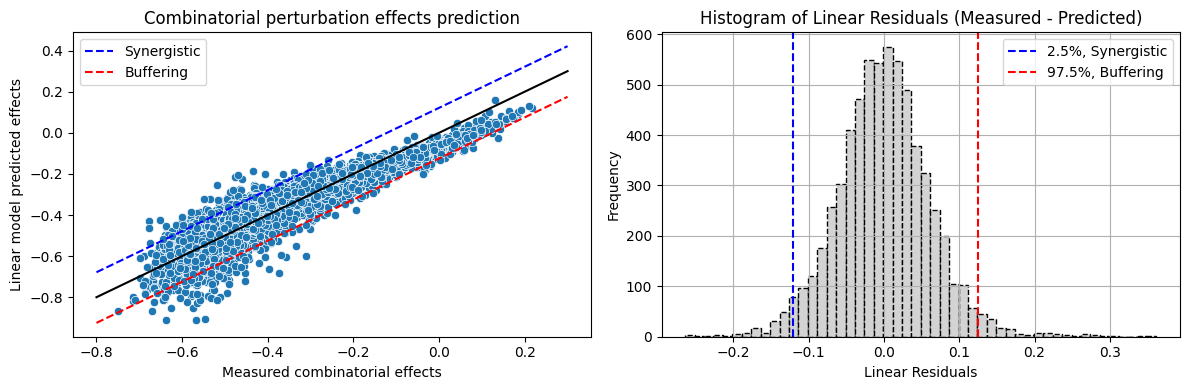

In [10]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(x='comb_score', y='linear_predicted', data=naiad_data)
plt.plot([-0.8, 0.3], [-0.8, 0.3], color='black' )
plt.plot([-0.8, 0.3], [-0.8 - lower_quant, 0.3 - lower_quant], color='blue', linestyle='--', label = 'Synergistic' )
plt.plot([-0.8, 0.3], [-0.8 - upper_quant, 0.3 - upper_quant], color='red', linestyle='--', label = 'Buffering' )
x_vals = np.linspace(-0.8, 0.3, 100)
 
plt.title("Combinatorial perturbation effects prediction")
plt.xlabel("Measured combinatorial effects")
plt.ylabel("Linear model predicted effects")
plt.legend() 


plt.subplot(1, 2, 2)
naiad_data['linear_residuals'].hist(bins=50, color='lightgrey', edgecolor='black', linestyle='--')
plt.axvline(lower_quant, color='blue', linestyle='--', label='2.5%, Synergistic')
plt.axvline(upper_quant, color='red', linestyle='--', label='97.5%, Buffering')
plt.title("Histogram of Linear Residuals (Measured - Predicted)")
plt.xlabel("Linear Residuals")
plt.ylabel("Frequency")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## Download Horlbeck Data

We access the Horlbeck Jurkat data from this URL: https://data.mendeley.com/datasets/rdzk59n6j4/1. 

This dataset shares many similar features with the Norman dataset, so the processing will be similar.

In [11]:
horlbeck_dir = './data/horlbeck_raw_data'

# Use some shell commands to download the files into a target directory
!mkdir '{horlbeck_dir}'
!wget 'https://data.mendeley.com/public-files/datasets/rdzk59n6j4/files/7ab168b7-3944-4f35-b249-5a672b32b20c/file_downloaded' -P '{horlbeck_dir}'
!unzip  -o '{os.path.join(horlbeck_dir, "file_downloaded")}'   -d  '{horlbeck_dir}'
!rm '{os.path.join(horlbeck_dir, "file_downloaded")}'

mkdir: ./data/horlbeck_raw_data: File exists
--2024-12-23 15:24:46--  https://data.mendeley.com/public-files/datasets/rdzk59n6j4/files/7ab168b7-3944-4f35-b249-5a672b32b20c/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/84a5c5f2-574d-4469-b9ff-9c21450db673 [following]
--2024-12-23 15:24:47--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/84a5c5f2-574d-4469-b9ff-9c21450db673
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.65.163, 52.92.18.90, 52.92.1.26, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu

In [12]:
horlbeck_data = pd.read_csv(os.path.join(horlbeck_dir, 'CRISPRi_Jurkat_all_pair_phenotypes.txt'), sep='\t')

horlbeck_data.head()

/var/folders/t3/wcrl2mr117z5sb7lfcmpg0tw0000gn/T/ipykernel_49799/1633949838.py:1: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  horlbeck_data = pd.read_csv(os.path.join(horlbeck_dir, 'CRISPRi_Jurkat_all_pair_phenotypes.txt'), sep='\t')


,Unnamed: 0,Triple Sequencing,Triple Sequencing.1,sgRNA Sequencing,sgRNA Sequencing.1,Barcode Sequencing,Barcode Sequencing.1
0,NaN,Replicate 1,Replicate 2,Replicate 1,Replicate 2,Replicate 1,Replicate 2
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AARS2_+_44281027.23-P1P2++AARS2_+_44281027.23-...,-0.0832550349677,-0.208204422149,-0.15589322304,-0.25314490123,-0.0785635910659,-0.19039927648
3,AARS2_+_44281027.23-P1P2++AARS2_+_44281044.23-...,-0.166878226682,-0.178913177538,-0.175819976716,-0.178862197243,-0.157838276089,-0.158146616817
4,AARS2_+_44281027.23-P1P2++AATF_-_35306286.23-P1P2,-0.157906418633,-0.161295489826,-0.178218281841,-0.190490319206,-0.158745626035,-0.160077426188


Like the Norman data, we will use the phenotype scores calculated from the 'Triple Sequencing' columns. The main difference between this dataset and the Norman dataset is that there are 2 replicates per guide pair. As a result, we will add an additional step of processing to average the phenotype score between these replicates.

The processing steps are similar, with the addition of a new step between 4 and 5:
1. Extract the relevant columns and rows from the data
2. Drop all entries that lack a cell viability score
3. Extract the gene names associated with the guides used in each combination
4. Store these gene names as new columns within the data frame
4b. Average scores between replicates for the same guide pair
5. Keep only the gene and score columns that will be used by NAIAD

Lastly, we will save the data to file.

In [13]:
# 1. Extract the relevant columns and rows from the data
# 2. Drop all entries that lack a cell viability score
horlbeck_data = horlbeck_data.iloc[1:, 0:3]                        # drop first row, and only take columns 0-2
horlbeck_data.columns = ['guides', 'score1', 'score2']             # rename the columns to something more convenient
horlbeck_data = horlbeck_data[~horlbeck_data['score1'].isna()]     # drop combinations from replicate 1 without a score
horlbeck_data = horlbeck_data[~horlbeck_data['score2'].isna()]     # drop combinations from replicate 1 without a score


# 3. Extract the gene names associated with the guides used in each combination
gene_pairs = horlbeck_data.iloc[:, 0]
g1, g2 = zip(*[[g.split('_')[0] for g in pair.split('++')] for pair in gene_pairs])


# 4. Store these gene names as new columns within the data frame
horlbeck_data['gene1'] = g1
horlbeck_data['gene2'] = g2

# 4b. Average scores between replicates for the same guide pair
horlbeck_data['score'] = (horlbeck_data['score1'].astype(np.float32) + horlbeck_data['score2'].astype(np.float32)) / 2

# 5. Keep only the gene and score columns that will be used by NAIAD
horlbeck_data = horlbeck_data.loc[:, ['gene1', 'gene2', 'score']]

# save data to file
horlbeck_comb_file = os.path.join(horlbeck_dir, 'horlbeck_gamma_score.csv')
horlbeck_data.to_csv(horlbeck_comb_file)

horlbeck_data.head()

,gene1,gene2,score
2,AARS2,AARS2,-0.145730
3,AARS2,AARS2,-0.172896
4,AARS2,AATF,-0.159601
5,AARS2,AATF,-0.222617
7,AARS2,ABCB7,-0.441518


In [14]:
# load data to use for NAIAD model
naiad_data = load_naiad_data(horlbeck_comb_file)
naiad_data.head()

,gene1,gene2,comb_score,g1_score,g2_score
0,AARS2,AARS2,-0.126785,-0.133196,-0.133196
1,AARS2,AATF,-0.186201,-0.133196,-0.150909
2,AARS2,ABCB7,-0.495732,-0.133196,-0.420355
3,ACTL6A,AARS2,-0.307017,-0.286111,-0.133196
4,ACTR10,AARS2,-0.173424,-0.088533,-0.133196
